In [1]:
### PREAMBLE
# Chapter 1 - Introduction to adversarial robustness
# noise.jpg

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from inspect import getfullargspec,signature

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import datasets


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [3]:
####################################
#Need to run the same with FashionMNIST
###################################


############################
class MnistResNet(nn.Module):
  def __init__(self, in_channels=1):
    super(MnistResNet, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = models.resnet50(pretrained=False)

    # Change the input layer to take Grayscale image, instead of RGB images.  **************
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 10 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)


my_resnet = MnistResNet()

input = torch.randn((16,1,244,244))
output = my_resnet(input)
print(output.shape)

print(my_resnet)

torch.Size([16, 10])
MnistResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

def get_data_loaders(train_batch_size, val_batch_size):
    fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))
                                        ])

    train_loader = DataLoader(torchvision.datasets.FashionMNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(torchvision.datasets.FashionMNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader


def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in signature(metric_fn).parameters:
        return metric_fn(true_y, pred_y, average="micro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")
        
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [16]:
print(torch.cuda.is_available())

True


In [5]:
# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
#norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
#model = resnet50(pretrained=True)
#model.eval();
# model:
model = MnistResNet().to(device)

# params you need to specify:
epochs = 150
batch_size = 128

# Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

# loss function and optimiyer
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # Using Karpathy's learning rate constant

start_ts = time.time()

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

/home/u21010246/.conda/envs/rob/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630841592/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/home/u21010246/.conda/envs/rob/lib/python3.9/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [8]:
# IF PRETRAINED  SKIP THIS SECTION

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, accuracy), 
                                   (precision_score, recall_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

            


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/150, training loss: 0.47155638379074616, validation loss: 0.3439166247844696
	     precision: 0.8720
	        recall: 0.8720
	            F1: 0.0000
	      accuracy: 0.8720


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/150, training loss: 0.2653298220241756, validation loss: 0.26805204153060913
	     precision: 0.9053
	        recall: 0.9053
	            F1: 0.0000
	      accuracy: 0.9053


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/150, training loss: 0.22087975438914573, validation loss: 0.2922322452068329
	     precision: 0.8953
	        recall: 0.8953
	            F1: 0.0000
	      accuracy: 0.8953


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/150, training loss: 0.19737504187550373, validation loss: 0.25958991050720215
	     precision: 0.9099
	        recall: 0.9099
	            F1: 0.0000
	      accuracy: 0.9099


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/150, training loss: 0.17248732377407647, validation loss: 0.3070117235183716
	     precision: 0.8994
	        recall: 0.8994
	            F1: 0.0000
	      accuracy: 0.8994


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/150, training loss: 0.15412448005858007, validation loss: 0.2274211049079895
	     precision: 0.9224
	        recall: 0.9224
	            F1: 0.0000
	      accuracy: 0.9224


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/150, training loss: 0.13832319271303953, validation loss: 0.22211728990077972
	     precision: 0.9284
	        recall: 0.9284
	            F1: 0.0000
	      accuracy: 0.9284


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/150, training loss: 0.12113100419373019, validation loss: 0.22184942662715912
	     precision: 0.9234
	        recall: 0.9234
	            F1: 0.0000
	      accuracy: 0.9234


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/150, training loss: 0.10405403772579518, validation loss: 0.27207133173942566
	     precision: 0.9174
	        recall: 0.9174
	            F1: 0.0000
	      accuracy: 0.9174


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/150, training loss: 0.08932548021075568, validation loss: 0.3146052956581116
	     precision: 0.9043
	        recall: 0.9043
	            F1: 0.0000
	      accuracy: 0.9043


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/150, training loss: 0.07919390185841366, validation loss: 0.29594385623931885
	     precision: 0.9184
	        recall: 0.9184
	            F1: 0.0000
	      accuracy: 0.9184


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/150, training loss: 0.0634558155481368, validation loss: 0.2861192524433136
	     precision: 0.9230
	        recall: 0.9230
	            F1: 0.0000
	      accuracy: 0.9230


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/150, training loss: 0.05945462508917427, validation loss: 0.3498552739620209
	     precision: 0.9201
	        recall: 0.9201
	            F1: 0.0000
	      accuracy: 0.9201


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/150, training loss: 0.04444323256631682, validation loss: 0.33449968695640564
	     precision: 0.9155
	        recall: 0.9155
	            F1: 0.0000
	      accuracy: 0.9155


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/150, training loss: 0.04778587480715073, validation loss: 0.34142380952835083
	     precision: 0.9154
	        recall: 0.9154
	            F1: 0.0000
	      accuracy: 0.9154


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/150, training loss: 0.03530377574410957, validation loss: 0.32932257652282715
	     precision: 0.9262
	        recall: 0.9262
	            F1: 0.0000
	      accuracy: 0.9262


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/150, training loss: 0.03255191909224748, validation loss: 0.35980015993118286
	     precision: 0.9223
	        recall: 0.9223
	            F1: 0.0000
	      accuracy: 0.9223


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/150, training loss: 0.030437011804520044, validation loss: 0.43554070591926575
	     precision: 0.9118
	        recall: 0.9118
	            F1: 0.0000
	      accuracy: 0.9118


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/150, training loss: 0.03976308360104082, validation loss: 0.355587363243103
	     precision: 0.9211
	        recall: 0.9211
	            F1: 0.0000
	      accuracy: 0.9211


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/150, training loss: 0.02417139168880852, validation loss: 0.35451582074165344
	     precision: 0.9296
	        recall: 0.9296
	            F1: 0.0000
	      accuracy: 0.9296


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21/150, training loss: 0.026368587316427904, validation loss: 0.36421671509742737
	     precision: 0.9261
	        recall: 0.9261
	            F1: 0.0000
	      accuracy: 0.9261


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22/150, training loss: 0.02664947229735891, validation loss: 0.3744155764579773
	     precision: 0.9264
	        recall: 0.9264
	            F1: 0.0000
	      accuracy: 0.9264


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23/150, training loss: 0.024527014950963, validation loss: 0.38823825120925903
	     precision: 0.9263
	        recall: 0.9263
	            F1: 0.0000
	      accuracy: 0.9263


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24/150, training loss: 0.02267701974577223, validation loss: 0.38528454303741455
	     precision: 0.9258
	        recall: 0.9258
	            F1: 0.0000
	      accuracy: 0.9258


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25/150, training loss: 0.01844169486154949, validation loss: 0.4145374596118927
	     precision: 0.9229
	        recall: 0.9229
	            F1: 0.0000
	      accuracy: 0.9229


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26/150, training loss: 0.02080851685468491, validation loss: 0.4400705397129059
	     precision: 0.9181
	        recall: 0.9181
	            F1: 0.0000
	      accuracy: 0.9181


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27/150, training loss: 0.015729195296343392, validation loss: 0.3753198981285095
	     precision: 0.9286
	        recall: 0.9286
	            F1: 0.0000
	      accuracy: 0.9286


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28/150, training loss: 0.018239766305217196, validation loss: 0.3823273181915283
	     precision: 0.9233
	        recall: 0.9233
	            F1: 0.0000
	      accuracy: 0.9233


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29/150, training loss: 0.022019420836571612, validation loss: 0.4146064221858978
	     precision: 0.9206
	        recall: 0.9206
	            F1: 0.0000
	      accuracy: 0.9206


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30/150, training loss: 0.01827631989860215, validation loss: 0.42486533522605896
	     precision: 0.9256
	        recall: 0.9256
	            F1: 0.0000
	      accuracy: 0.9256


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31/150, training loss: 0.010761598048725852, validation loss: 0.4714573323726654
	     precision: 0.9264
	        recall: 0.9264
	            F1: 0.0000
	      accuracy: 0.9264


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32/150, training loss: 0.018106151293399857, validation loss: 0.4037594795227051
	     precision: 0.9250
	        recall: 0.9250
	            F1: 0.0000
	      accuracy: 0.9250


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33/150, training loss: 0.015322161478865177, validation loss: 0.4392017126083374
	     precision: 0.9247
	        recall: 0.9247
	            F1: 0.0000
	      accuracy: 0.9247


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34/150, training loss: 0.011567445471494976, validation loss: 0.5158754587173462
	     precision: 0.9187
	        recall: 0.9187
	            F1: 0.0000
	      accuracy: 0.9187


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35/150, training loss: 0.016600680453825057, validation loss: 0.39930272102355957
	     precision: 0.9306
	        recall: 0.9306
	            F1: 0.0000
	      accuracy: 0.9306


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36/150, training loss: 0.009729330037242025, validation loss: 0.42102280259132385
	     precision: 0.9306
	        recall: 0.9306
	            F1: 0.0000
	      accuracy: 0.9306


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37/150, training loss: 0.01729521028721568, validation loss: 0.43494585156440735
	     precision: 0.9245
	        recall: 0.9245
	            F1: 0.0000
	      accuracy: 0.9245


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38/150, training loss: 0.010694039056037823, validation loss: 0.438610702753067
	     precision: 0.9242
	        recall: 0.9242
	            F1: 0.0000
	      accuracy: 0.9242


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39/150, training loss: 0.015220326493584317, validation loss: 0.46559756994247437
	     precision: 0.9259
	        recall: 0.9259
	            F1: 0.0000
	      accuracy: 0.9259


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40/150, training loss: 0.014787329312144984, validation loss: 0.4822005033493042
	     precision: 0.9204
	        recall: 0.9204
	            F1: 0.0000
	      accuracy: 0.9204


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41/150, training loss: 0.008755602627805658, validation loss: 0.44749704003334045
	     precision: 0.9317
	        recall: 0.9317
	            F1: 0.0000
	      accuracy: 0.9317


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42/150, training loss: 0.010277624485853152, validation loss: 0.4403742253780365
	     precision: 0.9265
	        recall: 0.9265
	            F1: 0.0000
	      accuracy: 0.9265


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43/150, training loss: 0.01136013267587298, validation loss: 0.44022539258003235
	     precision: 0.9328
	        recall: 0.9328
	            F1: 0.0000
	      accuracy: 0.9328


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44/150, training loss: 0.008852483073095423, validation loss: 0.49335041642189026
	     precision: 0.9225
	        recall: 0.9225
	            F1: 0.0000
	      accuracy: 0.9225


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45/150, training loss: 0.01329098643782151, validation loss: 0.4279744327068329
	     precision: 0.9180
	        recall: 0.9180
	            F1: 0.0000
	      accuracy: 0.9180


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46/150, training loss: 0.010695079220728959, validation loss: 0.427804172039032
	     precision: 0.9250
	        recall: 0.9250
	            F1: 0.0000
	      accuracy: 0.9250


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47/150, training loss: 0.011493554580424266, validation loss: 0.45977845788002014
	     precision: 0.9274
	        recall: 0.9274
	            F1: 0.0000
	      accuracy: 0.9274


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 48/150, training loss: 0.005522746711599434, validation loss: 0.48310360312461853
	     precision: 0.9287
	        recall: 0.9287
	            F1: 0.0000
	      accuracy: 0.9287


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49/150, training loss: 0.012919268049220906, validation loss: 0.4520092308521271
	     precision: 0.9315
	        recall: 0.9315
	            F1: 0.0000
	      accuracy: 0.9315


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50/150, training loss: 0.005495249942887196, validation loss: 0.4895588457584381
	     precision: 0.9312
	        recall: 0.9312
	            F1: 0.0000
	      accuracy: 0.9312


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51/150, training loss: 0.013001305679160817, validation loss: 0.48403677344322205
	     precision: 0.9255
	        recall: 0.9255
	            F1: 0.0000
	      accuracy: 0.9255


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52/150, training loss: 0.006600574414727456, validation loss: 0.43306902050971985
	     precision: 0.9338
	        recall: 0.9338
	            F1: 0.0000
	      accuracy: 0.9338


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53/150, training loss: 0.006832158924692334, validation loss: 0.5083478689193726
	     precision: 0.9273
	        recall: 0.9273
	            F1: 0.0000
	      accuracy: 0.9273


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54/150, training loss: 0.011514716335065437, validation loss: 0.45812004804611206
	     precision: 0.9266
	        recall: 0.9266
	            F1: 0.0000
	      accuracy: 0.9266


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55/150, training loss: 0.006310271573380375, validation loss: 0.44077399373054504
	     precision: 0.9351
	        recall: 0.9351
	            F1: 0.0000
	      accuracy: 0.9351


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56/150, training loss: 0.007179293695685132, validation loss: 0.4846588969230652
	     precision: 0.9308
	        recall: 0.9308
	            F1: 0.0000
	      accuracy: 0.9308


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57/150, training loss: 0.011362836040653827, validation loss: 0.43106210231781006
	     precision: 0.9294
	        recall: 0.9294
	            F1: 0.0000
	      accuracy: 0.9294


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58/150, training loss: 0.0028263422772288865, validation loss: 0.4624904692173004
	     precision: 0.9342
	        recall: 0.9342
	            F1: 0.0000
	      accuracy: 0.9342


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59/150, training loss: 0.005398473327745599, validation loss: 0.5243203639984131
	     precision: 0.9267
	        recall: 0.9267
	            F1: 0.0000
	      accuracy: 0.9267


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60/150, training loss: 0.013662533159913825, validation loss: 0.48417016863822937
	     precision: 0.9244
	        recall: 0.9244
	            F1: 0.0000
	      accuracy: 0.9244


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61/150, training loss: 0.007131765652173811, validation loss: 0.4618445932865143
	     precision: 0.9266
	        recall: 0.9266
	            F1: 0.0000
	      accuracy: 0.9266


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 62/150, training loss: 0.00566450645835693, validation loss: 0.49397340416908264
	     precision: 0.9295
	        recall: 0.9295
	            F1: 0.0000
	      accuracy: 0.9295


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 63/150, training loss: 0.006586572899216416, validation loss: 0.4652364253997803
	     precision: 0.9318
	        recall: 0.9318
	            F1: 0.0000
	      accuracy: 0.9318


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 64/150, training loss: 0.0024482451794531008, validation loss: 0.4812066853046417
	     precision: 0.9330
	        recall: 0.9330
	            F1: 0.0000
	      accuracy: 0.9330


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65/150, training loss: 0.010794327069861984, validation loss: 0.5336522459983826
	     precision: 0.9277
	        recall: 0.9277
	            F1: 0.0000
	      accuracy: 0.9277


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 66/150, training loss: 0.007042131122901166, validation loss: 0.4457332491874695
	     precision: 0.9319
	        recall: 0.9319
	            F1: 0.0000
	      accuracy: 0.9319


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 67/150, training loss: 0.004735836341902824, validation loss: 0.4888991415500641
	     precision: 0.9286
	        recall: 0.9286
	            F1: 0.0000
	      accuracy: 0.9286


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 68/150, training loss: 0.006025919837829744, validation loss: 0.5035784244537354
	     precision: 0.9296
	        recall: 0.9296
	            F1: 0.0000
	      accuracy: 0.9296


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 69/150, training loss: 0.008134853808298318, validation loss: 0.4979414641857147
	     precision: 0.9266
	        recall: 0.9266
	            F1: 0.0000
	      accuracy: 0.9266


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 70/150, training loss: 0.008343400529342663, validation loss: 0.5683320760726929
	     precision: 0.9214
	        recall: 0.9214
	            F1: 0.0000
	      accuracy: 0.9214


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 71/150, training loss: 0.0060550529989127225, validation loss: 0.4704437255859375
	     precision: 0.9306
	        recall: 0.9306
	            F1: 0.0000
	      accuracy: 0.9306


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 72/150, training loss: 0.0035231223745218862, validation loss: 0.47681742906570435
	     precision: 0.9323
	        recall: 0.9323
	            F1: 0.0000
	      accuracy: 0.9323


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 73/150, training loss: 0.0011943842887749676, validation loss: 0.5354706048965454
	     precision: 0.9291
	        recall: 0.9291
	            F1: 0.0000
	      accuracy: 0.9291


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
torch.save(model.state_dict(), "./MnistResNet")    
model = MnistResNet()
model_state_dict = torch.load("./MnistResNet")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

tensor([[[[-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          ...,
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103]]],


        [[[-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          ...,
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103]]],


        [[[-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.810

'\n   \n fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root=".").train_data.float()\n# eval on our pig image\ntraining_data = datasets.FashionMNIST(\n    root="data",\n    train=True,\n    download=True,\n    transform=transforms.Compose([  # \n       transforms.Resize(224), #min size for pytorch\n       transforms.ToTensor(),\n       transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,)),\n    ])\n)\nlabels_map = {\n    0: "T-Shirt",\n    1: "Trouser",\n    2: "Pullover",\n    3: "Dress",\n    4: "Coat",\n    5: "Sandal",\n    6: "Shirt",\n    7: "Sneaker",\n    8: "Bag",\n    9: "Ankle Boot",\n}\n#figure = plt.figure(figsize=(8, 8))\ncols, rows = 1, 1\n#for i in range(1, cols * rows + 1):\n#    sample_idx = torch.randint(len(training_data), size=(1,)).item()\nsample_idx=9406\nimg, label = training_data[sample_idx]\n    #figure.add_subplot(rows, cols, i)\nplt.title(labels_map[label])\nimg_tensor = img[None,:,:,:]\n#plt.imshow(img_t

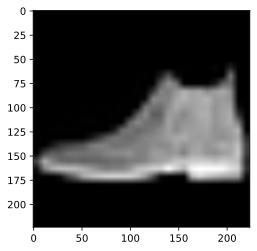

In [38]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

for i, data in enumerate(val_loader) :
    if i <1:
        X, y = data[0], data[1]
        print(X,y)
        #plt.title(labels_map[y[0].to(device)])
        #plt.imshow(  transforms.ToPILImage(X[0]))  
        plt.imshow(X[0].squeeze(), cmap="gray")
    else:
        exit

plt.imshow(X[0].squeeze(), cmap="gray")

"""
   
 fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root=".").train_data.float()
# eval on our pig image
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([  # 
       transforms.Resize(224), #min size for pytorch
       transforms.ToTensor(),
       transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,)),
    ])
)
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
#figure = plt.figure(figsize=(8, 8))
cols, rows = 1, 1
#for i in range(1, cols * rows + 1):
#    sample_idx = torch.randint(len(training_data), size=(1,)).item()
sample_idx=9406
img, label = training_data[sample_idx]
    #figure.add_subplot(rows, cols, i)
plt.title(labels_map[label])
img_tensor = img[None,:,:,:]
#plt.imshow(img_tensor[0].numpy().transpose(1,2,0))
plt.imshow(img.squeeze(), cmap="gray")

"""


In [40]:
#norm = transforms.Compose([
#         transforms.ToTensor(),
#        transforms.Normalize((training_data.train_data.float().mean()/255,), 
#                            (training_data.train_data.float().std()/255,)),
#])

pred = model(X[0].unsqueeze(0).cuda())

In [42]:
pred
#print(labels_map[pred.max(dim=1)[1].item()])

tensor([[ 0.0846, -0.5368,  0.3481, -0.0854, -0.5416, -0.2399,  0.6279,  0.1358,
         -0.1966, -0.0821]], device='cuda:0', grad_fn=<AddmmBackward>)

FROM HERE ONWARD WE INVESTIGATE PGD attack. DO Not train the model , just reload it from disk. 
Always re-run the imports(first cell in notebook) 

In [10]:
model = MnistResNet()
model_state_dict = torch.load("./MnistResNet")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [13]:
epsilon = 2./255

delta = torch.zeros_like(img_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(img_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([3]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,3].item())

0 -3.1294689178466797
5 -3.5980424880981445
10 -3.7788288593292236
15 -3.8711800575256348
20 -3.925316333770752
25 -3.975167751312256
True class probability: 0.01836887188255787


In [14]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", labels_map[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  T-Shirt
Predicted probability: 0.3618265986442566


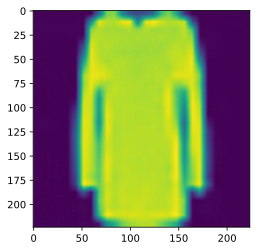

In [15]:
plt.imshow((img_tensor + delta)[0].detach().numpy().transpose(1,2,0))

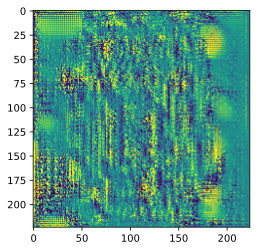

In [18]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [19]:
## TARGETED attach. Maximise the loss of Dress but minimize loss of T-shirt

delta = torch.zeros_like(img_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(img_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([3])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([0])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 -2.1406612396240234
10 -2.3440780639648438
20 -2.4047679901123047
30 -2.4643893241882324
40 -2.5147743225097656
50 -2.5605010986328125
60 -2.599435567855835
70 -2.6361231803894043
80 -2.668154716491699
90 -2.69689679145813


In [20]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", labels_map[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  T-Shirt
Predicted probability: 0.4259525537490845


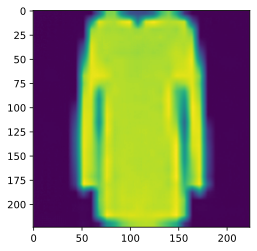

In [23]:
plt.imshow((img_tensor + delta)[0].detach().numpy().transpose(1,2,0))

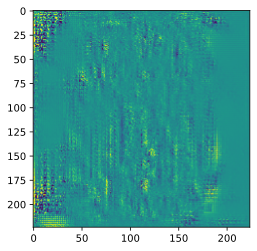

In [24]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
